In [2]:
import torch
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler
from transformers import CLIPVisionModelWithProjection
from controlnet_aux import OpenposeDetector
from IPython.display import display, HTML
import io
import numpy as np
import base64

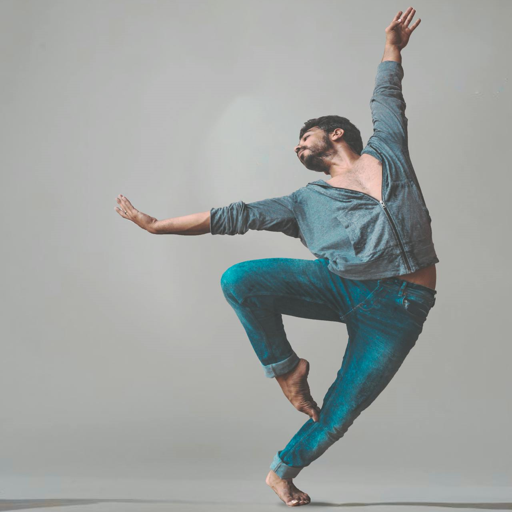

In [3]:
# ポーズ検出前の画像
pose_source_img = load_image("dancing_man.png")
pose_source_img = pose_source_img.resize((512, 512))

pose_source_img

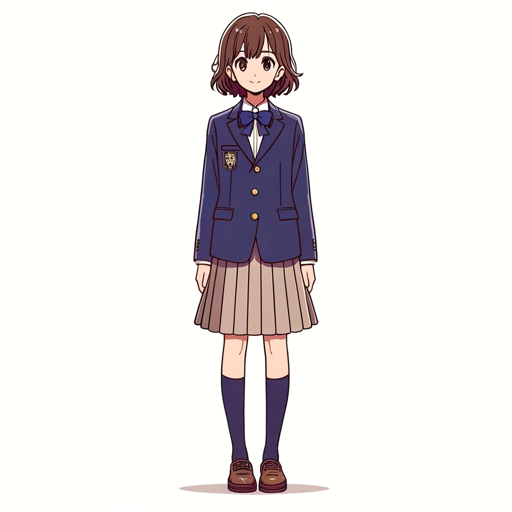

In [4]:
# IP Adapterにいれる画像
ip_adapter_image = load_image("school_girl.png")
ip_adapter_image = ip_adapter_image.resize((512, 512))

ip_adapter_image

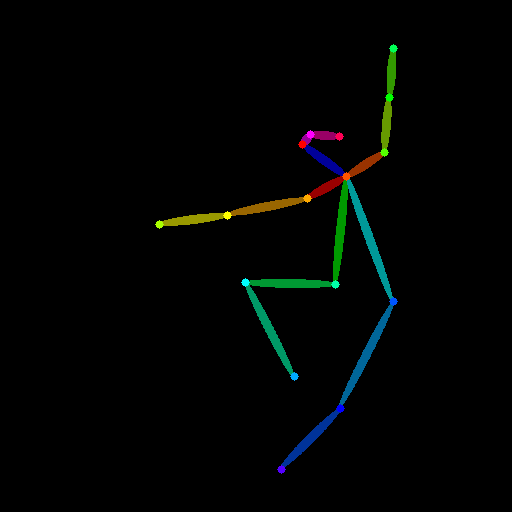

In [5]:
# ポーズ画像の準備
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
pose_image = openpose_detector(pose_source_img)

pose_image

In [6]:
# ControlNet
controlnet_pose = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose",
    torch_dtype=torch.float16
).to("cuda")

# Stable Diffusion Model
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "JosephusCheung/ACertainThing",
    controlnet=[controlnet_pose],
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at /root/.cache/huggingface/hub/models--JosephusCheung--ACertainThing/snapshots/f29dbc8b2737fa20287a7ded5c47973619b5c012/text_encoder were not used when initializing CLIPTextModel: ['text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.11.layer_norm1.weight', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.11.layer_norm2.weight', 'text_model.encoder.layers.11.mlp.fc1.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.11.mlp.fc2.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layer

In [7]:
# Scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    algorithm_type="sde-dpmsolver++",
    use_karras_sigmas=True
)

# ImageEncoder (CLIP)
pipe.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",  
    subfolder="models/image_encoder", 
    torch_dtype=torch.float16,).to("cuda")


In [8]:
# 画像をバイトデータに変換するヘルパー関数
def pil_to_base64(image):
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        data = output.getvalue()
    return base64.b64encode(data).decode('utf-8')

# 2x2のHTMLテーブルを作成
def display_images(images):
    html_str = '<table>'
    n = int(np.ceil(np.sqrt(len(images))))
    for i in range(0, len(images), n):
        html_str += '<tr>'
        for j in range(n):
            if i + j < len(images):
                img_data = pil_to_base64(images[i + j])
                html_str += f'<td><img src="data:image/png;base64,{img_data}" style="margin: 10px; height: 512px;"></td>'
        html_str += '</tr>'
    html_str += '</table>'
    return display(HTML(html_str))

## IP Adapter Original

In [9]:
# IP-Adapter
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name="ip-adapter_sd15.safetensors" # ip-adapter-plus_sd15.safetensors"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,
,

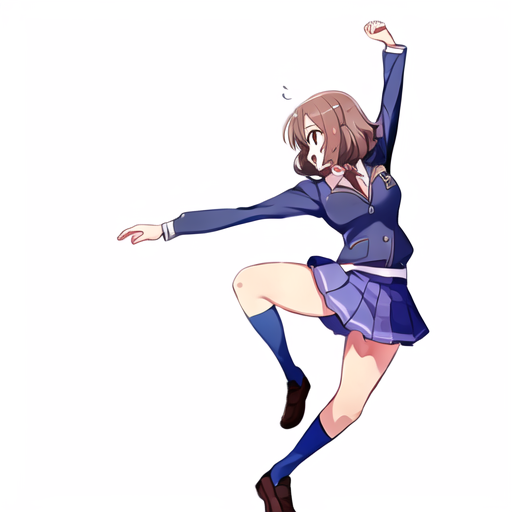
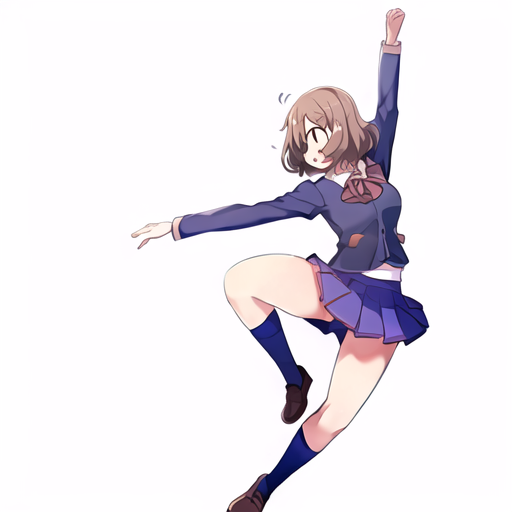
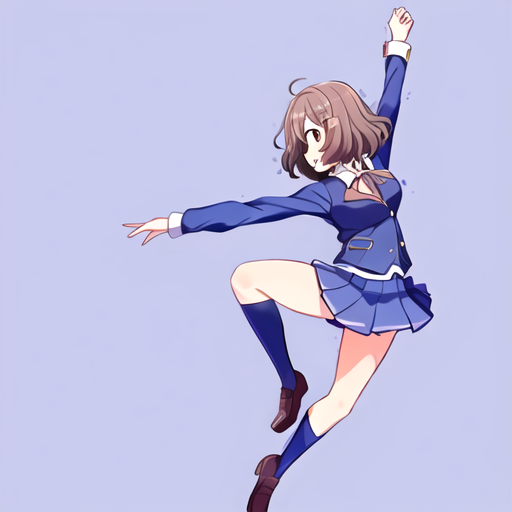
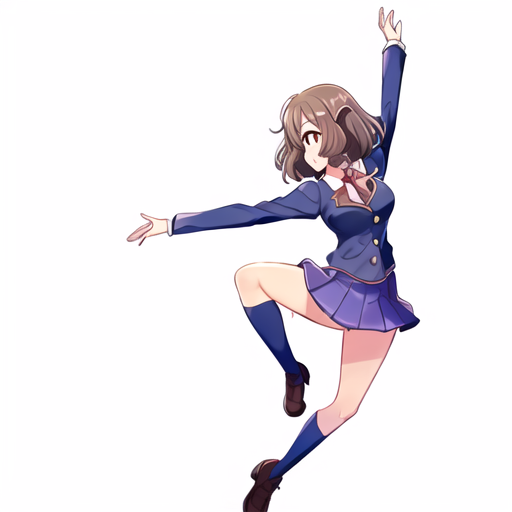

In [11]:
images = []

for i in range(4):
    image = pipe(
        "1girl, dancing, best quality",
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_inference_steps=50,
        generator=torch.Generator().manual_seed(i),
        image=[pose_image],
        ip_adapter_image=ip_adapter_image,
        clip_skip=2
    ).images[0]
    images.append(image)


display_images(images)

## IP Adapter Plus

In [12]:
# IP-Adapter
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name="ip-adapter-plus_sd15.safetensors"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,
,

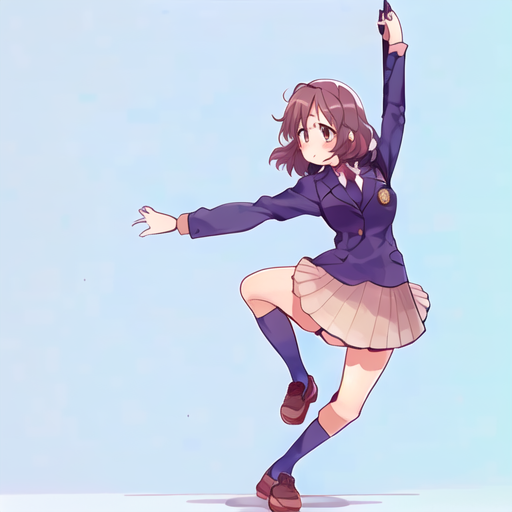
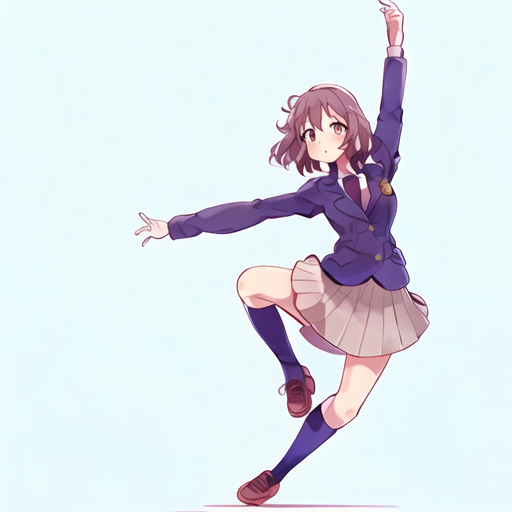
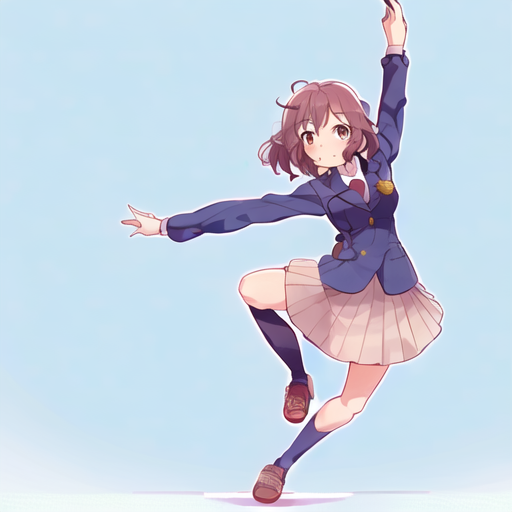
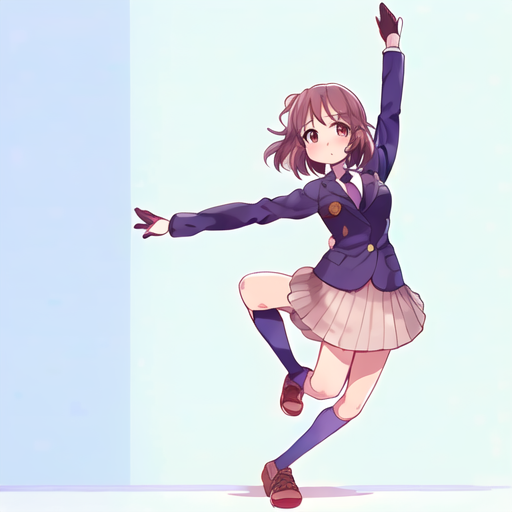

In [13]:
images = []

for i in range(4):
    image = pipe(
        "1girl, dancing, best quality",
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_inference_steps=50,
        generator=torch.Generator().manual_seed(i),
        image=[pose_image],
        ip_adapter_image=ip_adapter_image,
        clip_skip=2
    ).images[0]
    images.append(image)


display_images(images)

In [14]:
## VRAM6GB程度

## Multiple IP Adapter

In [16]:
# IP-Adapter + Plus
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter_sd15.safetensors"
    ]
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,
,

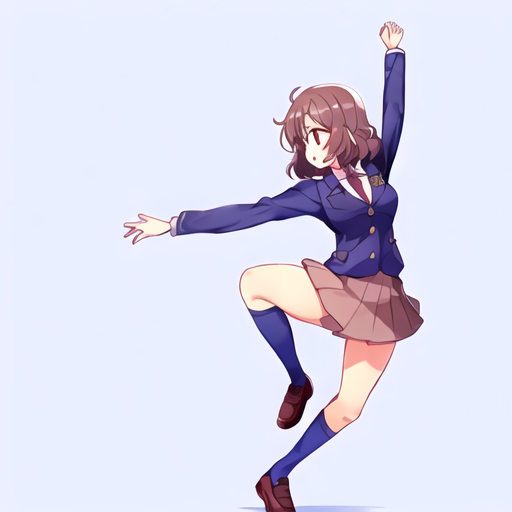
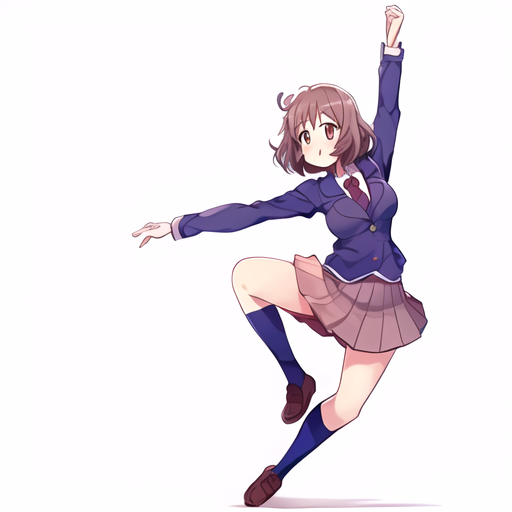
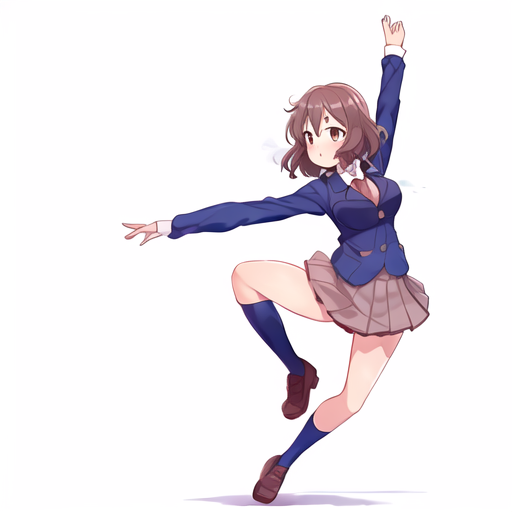
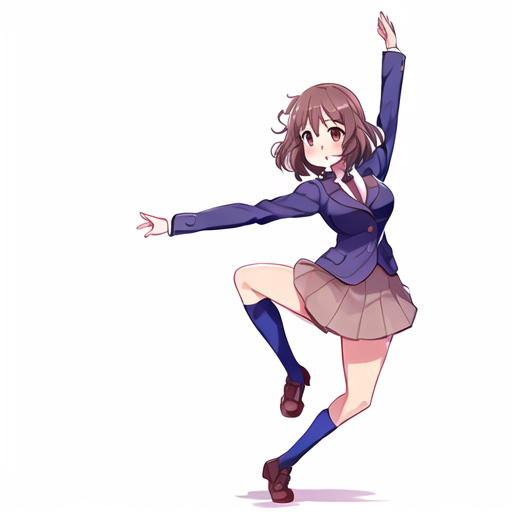

In [21]:
pipe.set_ip_adapter_scale([0.4, 0.6])
images = []

for i in range(4):
    image = pipe(
        "1girl, dancing, best quality",
        negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
        num_inference_steps=50,
        generator=torch.Generator().manual_seed(i),
        image=[pose_image],
        ip_adapter_image=[ip_adapter_image, ip_adapter_image],
        clip_skip=2
    ).images[0]
    images.append(image)


display_images(images)
